In [1]:
import os
gpu_num = 0 # 使用 "" 来启用 CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import mitsuba as mi

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.utils.metrics import compute_ber
# Import Sionna RT components
from mysionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera
from sensing.scene import SensingScene

In [3]:
# tx_positions = np.array([[-111,36,40],[0,0,30]])
# tx_look_dir = np.array([[-111,36,0],[-111,36,0]])
tx_positions = np.array([[0,0,2.95]])
tx_look_dir = np.array([[0,0,0]])
scene = SensingScene("./Indoor/indoor.xml", tx_positions=tx_positions, tx_look_dir=tx_look_dir)

In [4]:
# map_position = [-300,-100,1.5]
# map_size = 400
# cell_size = 4
# tx_positions = np.array([[-111,36,40]])
# tx_look_dir = np.array([[-111,36,0]])
tx_positions = np.array([[0,0,2.95],[0,-4.99,2.95]])
tx_look_dir = np.array([[0,0,0],[0,0,0]])
scene.set_tx(tx_positions,tx_look_dir)
map_center = [0,0,0.65]
map_size_x = 6
map_size_y = 10
cell_size = 0.1
cell_positions = scene.set_cell_positions(map_center,map_size_x,map_size_y,cell_size)

In [5]:
paths = scene.compute_paths(max_depth=4,num_samples=1000000,max_rx_each_turn=1000,scattering=False,diffraction=True)

In [7]:
paths[0].objects

<tf.Tensor: shape=(4, 1000, 2, 139), dtype=int32, numpy=
array([[[[-1,  3,  2, ...,  9, -1, -1],
         [-1,  8, 10, ..., -1, -1, -1]],

        [[-1,  3,  3, ...,  9, -1, -1],
         [-1, 11,  8, ..., -1, -1, -1]],

        [[-1,  3,  3, ...,  9, -1, -1],
         [-1, 11,  8, ..., -1, -1, -1]],

        ...,

        [[-1,  3,  3, ...,  9, 12, -1],
         [-1,  2,  9, ..., 30,  9, -1]],

        [[-1,  3,  3, ...,  9, 12, -1],
         [-1,  2,  9, ..., 30,  9, -1]],

        [[-1,  3,  3, ...,  9, 12, -1],
         [-1,  2,  8, ..., 30,  9, -1]]],


       [[[-1,  0,  9, ..., -1, -1, -1],
         [-1,  9, 11, ..., -1, -1, -1]],

        [[-1,  0,  0, ..., -1, -1, -1],
         [-1,  2,  9, ..., -1, -1, -1]],

        [[-1,  0,  0, ..., -1, -1, -1],
         [-1,  2,  9, ..., -1, -1, -1]],

        ...,

        [[-1,  0,  0, ..., -1, -1, -1],
         [-1,  9,  2, ..., -1, -1, -1]],

        [[-1,  0,  0, ..., -1, -1, -1],
         [-1,  9,  2, ..., -1, -1, -1]],

        [[-

In [10]:
scene.scene.mi_scene.shapes

<bound method PyCapsule.shapes of Scene[
  children = [
    PathIntegrator[
      max_depth = 12,
      rr_depth = 5
    ],
    DirectionalEmitter[
      irradiance = SRGBReflectanceSpectrum[
        value = [[1, 1, 1]]
      ],
      bsphere = BoundingSphere3f[
        center = [0.024092, 0, 1.74465],
        radius = 6.10189
      ],
    ],
    SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [[0.8, 0.8, 0.8]]
      ]
    ],
    SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [[0.8, 0.8, 0.8]]
      ]
    ],
    SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [[0.8, 0.8, 0.8]]
      ]
    ],
    SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [[0.8, 0.4, 0.4]]
      ]
    ],
    PLYMesh[
      name = "ceiling-itu_ceiling_board.ply",
      bbox = BoundingBox3f[
        min = [-3, -5, 3.5],
        max = [3, 5, 3.5]
      ],
      vertex_count = 4,
      vertices = [80 B of ve

In [32]:
crb = scene.compute_crb(1)

/root/sionna/sionna/sensing/scene.py:274: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(crb))


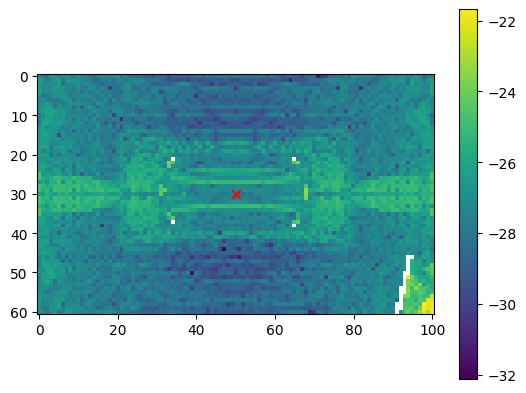

In [33]:
fig = scene.heat_map(tx=0)

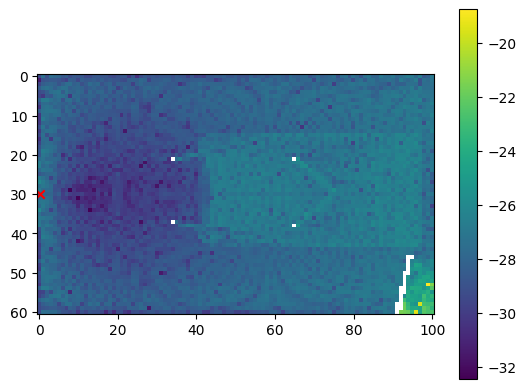

In [34]:
fig1=scene.heat_map(tx=1)

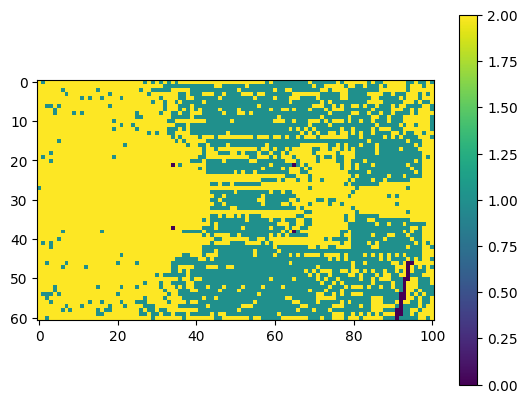

In [35]:
max_idx = np.argmin(crb,axis=0)
max_idx = np.where(max_idx==0,1,2)
max_idx = np.where(np.logical_and(crb[0]==0,crb[1]==0),0,max_idx)
plt.imshow(max_idx)
plt.colorbar()

In [ ]:
scene.render()

In [6]:
scene.scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [17]:
paras = mi.traverse(scene._scene.mi_scene)
shapes = scene.scene.mi_scene.shapes()

In [19]:
rectangle = mi.load_dict({
'type': 'rectangle',
'material': {
    'type': 'diffuse',
    'reflectance': {
        'type': 'checkerboard',
        'to_uv': mi.ScalarTransform4f.scale([5, 5, 1])
    }
}})

In [ ]:
cm = scene.scene.coverage_map(cm_cell_size=(0.1,0.1))
cm.show(tx=1)